In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.probability_models import ProbabilityAttentionRNN
from models.energy_models import EnergyAttentionRNN, EnergyAttentionRNN2D
from data_utils.pytorch_datasets import EnergyDataset, EnergyDataset2D
from plotting_utils.attention import attention_2D_viz, attention_1D_viz

In [2]:
energy_attn_ckpt = './model_weights/energy/rnn_attn/GRU_1L_1H/model.ckpt'
energy_2D_attn_ckpt = './model_weights/energy/rnn_attn/2D_GRU_1L_1H/model.ckpt'
prob_attn_ckpt = './model_weights/probability/rnn_attn/GRU_1L_1H/model.ckpt'

energy_attn = EnergyAttentionRNN.load_from_checkpoint(energy_attn_ckpt)
energy_attn.eval()

energy_2D_attn = EnergyAttentionRNN2D.load_from_checkpoint(energy_2D_attn_ckpt)
energy_2D_attn.eval()

prob_attn = ProbabilityAttentionRNN.load_from_checkpoint(prob_attn_ckpt)
prob_attn.eval();

In [3]:
train_data_path = './data/train_data.hdf5'
batch_size = 128
n_random_samples = 3200

dataset = EnergyDataset2D(filepath=train_data_path)
random_sampler = RandomSampler(dataset, num_samples=n_random_samples, replacement=True)
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=random_sampler,
    num_workers=0)

In [4]:
attn_2D_rows = {}
attn_2D_cols = {}

attn_1D = {}
with torch.no_grad():
    for x_row, x_col, y in tqdm(loader):
        y_pred, attn_weights = energy_2D_attn(x_row, x_col)
        if y_pred.shape[0] == batch_size:
            attn_2D_rows['energy_2D'] = attn_2D_rows.get('energy_2D', 0) + attn_weights[0]
            attn_2D_cols['energy_2D'] = attn_2D_cols.get('energy_2D', 0) + attn_weights[1]
            
        y_pred, attn_weights = energy_attn(x_row)
        if y_pred.shape[0] == batch_size:
            attn_1D['energy'] = attn_1D.get('energy', 0) + attn_weights
        
        y_pred, attn_weights = prob_attn(x_row)
        if y_pred.shape[0] == batch_size:
            attn_1D['prob'] = attn_1D.get('prob', 0) + attn_weights

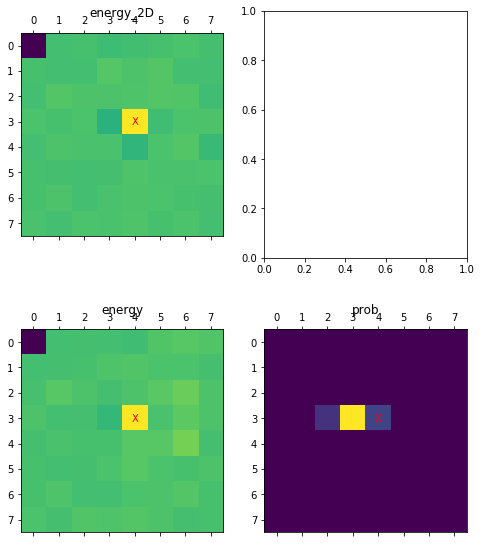

In [11]:
row, col = 3, 4
fig, ax = plt.subplots(2, 2, figsize=(8, 10))
for i, model_key in enumerate(attn_2D_rows.keys()):
    attn_weights_sum = (attn_2D_rows[model_key], attn_2D_cols[model_key])
    attn_viz = attention_2D_viz(attn_weights_sum, row, col)
    ax[0, i].matshow(attn_viz)
    ax[0, i].text(col, row, "X",ha="center", va="center", color="r")
    ax[0, i].set_title(model_key)

for i, model_key in enumerate(attn_1D.keys()):
    attn_viz = attention_1D_viz(attn_1D[model_key], row, col)
    ax[1, i].matshow(attn_viz)
    ax[1, i].text(col, row, "X",ha="center", va="center", color="r")
    ax[1, i].set_title(model_key)